In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Test du calcul de la divergence sur une solution analytique
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"

# Importations
## Modules

In [2]:
# Importation des librairies
from mat4py import loadmat #pour charger des .mat
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np # pour travailler avec des array
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)

import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver

import scipy as sc #pour l'analyse
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

import fonctions_projet_divergence as fpd

## colormap

In [3]:
colormap2=cm.RdBu#colormap

# Chargement des données

In [4]:
# Chargement des données:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

prof=10 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
plan=2
    
u,v,x,y=fpd.donnees(prof, plan, manips)

print(x.any()==0)
print(np.shape(x))

False
(60, 60)


# Solution analytique : disque bougeant à la surface d'un liquide

Ces solutions analytiques concernent spécifiquement le cas d’un disque bougeant à la surface d’un liquide,
dans un repère cylindrique centré sur un nageur disque de rayon unité. On se place en z=0.

## Implémentation des fonctions
### Convertion coordonnées 
Les solutions sont données en coordonnées cylindrique, on se place en cartésien


In [5]:
def r_cartésien(x,y):
    "Donne r cylindrique pour x et y donnés"
    return(np.sqrt(x**2+y**2))

def theta_cartésien1(x,y):
    "Donne theta cylindrique pour x et y donnés (ne marche que parce que x.any()==0 False)"
    return(np.arctan(y/x)+np.pi/2-np.sign(x)*np.pi/2)


def theta_cartésien2(x,y):
    "Donne theta cylindrique pour x et y donnés (ne marche que parce que x.any()==0 False)"
    return(np.where(x>0,np.arctan(y/x),np.arctan(y/x)+np.pi))

### Solutions analytiques

Ce sont les solutions pour u/U (normalisées)

In [6]:
def u_r(x,y):
    "Retourne la coordonnée suivant e_r de la solution analytique"
    r=r_cartésien(x,y)
    theta=theta_cartésien1(x,y)
    return(Xi*np.cos(theta)*(np.sqrt(r**2-1)/r**2+3*np.arcsin(1/r)))

def u_theta(x,y):
    "Retourne la coordonnée suivant e_theta de la solution analytique"
    r=r_cartésien(x,y)
    theta=theta_cartésien1(x,y)
    return(Xi*np.cos(theta)*(np.sqrt(r**2-1)/r**2-3*np.arcsin(1/r)))

def divergence_analytique(x,y):
    r=r_cartésien(x,y)
    theta=theta_cartésien1(x,y)
    return(Xi*np.cos(theta)*(-3*np.sqrt(1-1/r**2)/(r**2-1)+1/(r*np.sqrt(r**2-1))))


In [7]:
#fixation de Xi
Xi=2/(3*np.pi)

### Petits tests

In [8]:
a=np.random.rand(6,5)
b=np.random.rand(6,5)
theta_test1=theta_cartésien1(a,b)
theta_test2=theta_cartésien2(a,b)

print(a*b,np.shape(a*b))
#print(theta_test1)
#print(theta_test2)      

[[0.01981811 0.05156433 0.00351439 0.01154569 0.34978321]
 [0.01549618 0.14641755 0.00085689 0.66668531 0.38457271]
 [0.79444782 0.15076866 0.07670508 0.07270261 0.08961245]
 [0.05956786 0.72990551 0.21492549 0.65195546 0.36687235]
 [0.19210915 0.62087233 0.27956523 0.32294724 0.02211672]
 [0.02903038 0.13436988 0.35821675 0.17172162 0.05517058]] (6, 5)


Les deux fonctions ont l'air de marcher.

## Tracé de la divergence analytique avec la formule
### Fonction de plot

In [9]:
def plot_divergence(div,title):
    "Fonction pour plot la divergence"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=100).tick_values(div.min(), div.max())
    
    fig, (l0,l1) = plt.subplots(nrows=1,ncols=2,num=title)
    im0=l0.pcolormesh(x,y,div,cmap=colormap2,norm=norm)
    l0.set_title("Brut")
    fig.colorbar(im0,ax=l0)
    im1 = l1.contourf(x,y,div,levels=levels, cmap=colormap2,norm=norm)
    l1.set_title("Avec courbe de niveau")
    fig.colorbar(im1,ax=l1)
    
    fig.tight_layout(pad=2.5)
    fig.suptitle(title,fontsize=16)
    plt.show()

### Chargement des tableaux

In [10]:
div_analytique=divergence_analytique(x,y)
print(np.shape(div_analytique))
print(np.max(div_analytique),np.min(div_analytique))
print(div_analytique)

(60, 60)
0.11973220871963527 -0.11973220871963526
[[ 2.75557471e-05  2.80048988e-05  2.84254782e-05 ... -2.84254782e-05
  -2.80048988e-05 -2.75557471e-05]
 [ 2.89756059e-05  2.94992267e-05  2.99962130e-05 ... -2.99962130e-05
  -2.94992267e-05 -2.89756059e-05]
 [ 3.04668051e-05  3.10732763e-05  3.16558098e-05 ... -3.16558098e-05
  -3.10732763e-05 -3.04668051e-05]
 ...
 [ 3.04668051e-05  3.10732763e-05  3.16558098e-05 ... -3.16558098e-05
  -3.10732763e-05 -3.04668051e-05]
 [ 2.89756059e-05  2.94992267e-05  2.99962130e-05 ... -2.99962130e-05
  -2.94992267e-05 -2.89756059e-05]
 [ 2.75557471e-05  2.80048988e-05  2.84254782e-05 ... -2.84254782e-05
  -2.80048988e-05 -2.75557471e-05]]


### Plot

<IPython.core.display.Javascript object>


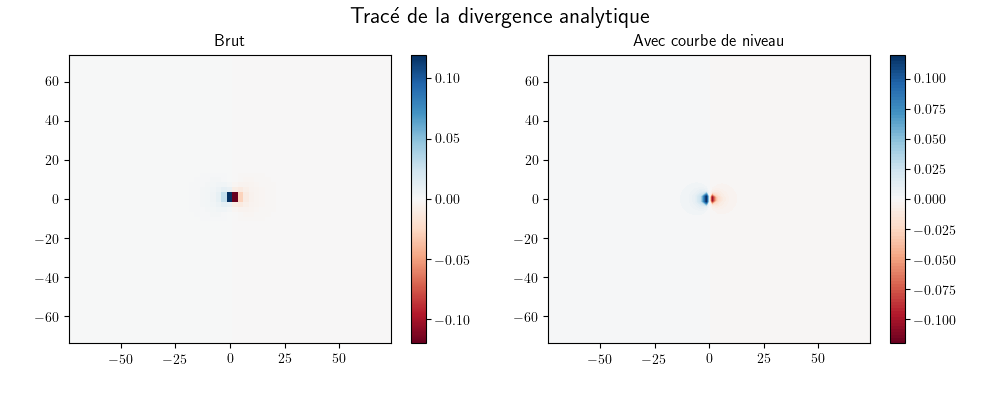

In [17]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,4]
plot_divergence(div_analytique,"Tracé de la divergence analytique")

# Test du programme
## Définition des fonctions de plot

In [12]:
def plot_champ_vitesse(u,v,x,y,title):
    #bidouillage norme
    velocity=np.sqrt(u**2+v**2)
    colors = velocity
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors[velocity>velmax]=velmax
    norm = Normalize()
    norm.autoscale(colors)

    #plot   
    fig,ax=plt.subplots(num=title)
    im=ax.quiver(x,y,u/velocity,v/velocity,colors)
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


## Constitution des tableaux

On travaille ici avec les données v_r et v_theta analytiques, auquelles on va ensuite appliquer le programme utilisé dans Projet_Divergence pour calculer la divergence.
### v_r et v_theta

In [13]:
v_r=u_r(x,y)
v_theta=u_theta(x,y)

### Transformation en v_x et v_y

*voir pour améliorer norme des vecteurs*

In [14]:
#theta
theta=theta_cartésien1(x,y)

#vitesses
v_x=v_r*np.cos(theta)-v_theta*np.sin(theta)
v_y=v_r*np.sin(theta)+v_theta*np.cos(theta)

print(np.shape(v_x),np.shape(v_y))

(60, 60) (60, 60)


### Plot du champ de vitesse

<IPython.core.display.Javascript object>


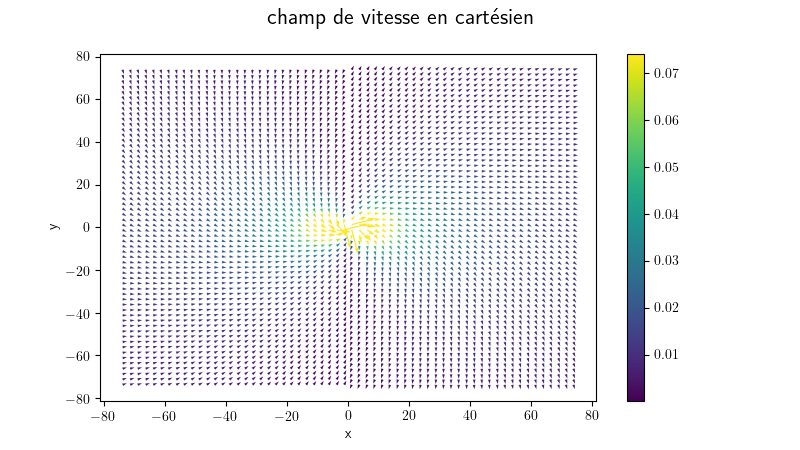

In [18]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [8,4.5]
plot_champ_vitesse(v_x,v_y,x,y, "champ de vitesse en cartésien")

## Application du programme sans filtrage
### Constitution des tableaux

In [22]:
"Dérivation"
du,dv=fpd.deriv(v_x,x,1),fpd.deriv(v_y,y,0)
dx,dy=fpd.abcisse(x,1),fpd.abcisse(y,0)

"Remise à la bonne taille"
du,dv=fpd.good_shape(du),fpd.good_shape(dv)
dx,dy=fpd.good_shape(dx),fpd.good_shape(dy)

"somme des tableaux"
div_numerique = fpd.divergence2D(du,dv)
print(np.shape(dx))
print(np.max(div_analytique),np.min(div_analytique),np.mean(div_analytique),np.std(div_analytique))
vmin,vmax=np.max(div_analytique),np.min(div_analytique)

(59, 59)
0.11973220871963527 -0.11973220871963526 8.251983201695229e-21 0.004167385834518869


### Plot
#### Fonction de plot

In [23]:
def plot_divergence_num(div,title):
    "Fonction pour plot la divergence"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=100).tick_values(div.min(), div.max())
    
    fig, (l0,l1) = plt.subplots(nrows=1,ncols=2,num=title)
    im0=l0.pcolormesh(dx,dy,div,cmap=colormap2,norm=norm)
    l0.set_title("Brut")
    fig.colorbar(im0,ax=l0)
    im1 = l1.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    l1.set_title("Avec courbe de niveau")
    fig.colorbar(im1,ax=l1)
    
    fig.tight_layout(pad=2.5)
    fig.suptitle(title,fontsize=16)
    plt.show()

#### plot

<IPython.core.display.Javascript object>


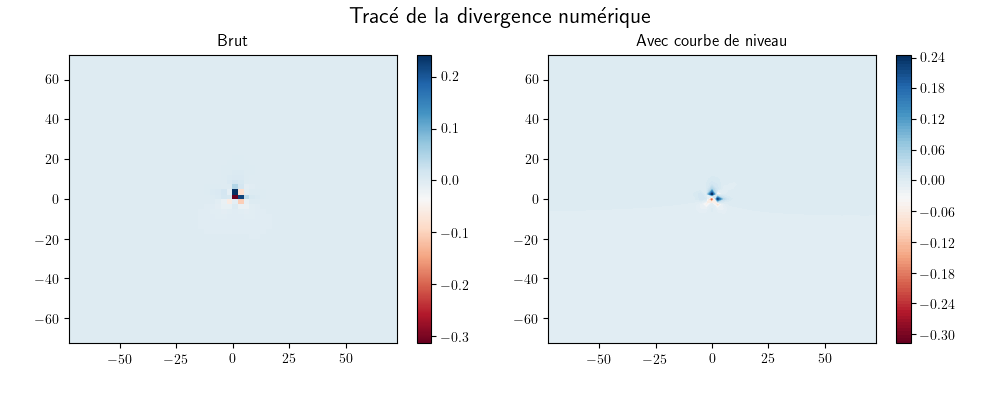

In [26]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,4]
plot_divergence_num(div_numerique,"Tracé de la divergence numérique")

## Application du programme avec filtrage (sigma=1)
### Constitution des tableaux

In [28]:
#choix de sigma
sigma=1

#Tableaux
u_filtre=fpd.gaussian_filter(v_x,sigma)
v_filtre=fpd.gaussian_filter(v_y,sigma)

#dérivation
du_filtre,dv_filtre=fpd.deriv(u_filtre,x,1),fpd.deriv(v_filtre,y,0)
#shape
du_filtre,dv_filtre=fpd.good_shape(du_filtre),fpd.good_shape(dv_filtre)
#somme
div_numerique_filtre = fpd.divergence2D(du_filtre,dv_filtre)
print(np.shape(div_numerique_filtre))
print(np.max(div_numerique),np.min(div_numerique),np.mean(div_numerique),np.std(div_numerique))
vmin,vmax=np.max(div_numerique),np.min(div_numerique)

(59, 59)
0.24248249714444847 -0.31365163410712604 -1.4011978519755223e-06 0.008209300042839408


# Comparaison des procédures
## Fonction de tracé

In [29]:
def plot_comparaison_divergence(div0,div1,div2,title,m):
    "Fonction pour plot la comparaison, mettre div_analytique en premier"
    if m==3:
        #norme
        extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1),np.max(div2),np.min(div1)])
        vmax,vmin=np.max(extremums),np.min(extremums)
        norm=Normalize(vmin=vmin, vmax=vmax)
        levels = MaxNLocator(nbins=100).tick_values(vmin, vmax)

        #Figure
        fig, (l0,l1,l2) = plt.subplots(nrows=3,ncols=1,num=title)
        im0 = l0.contourf(x,y,div0,levels=levels, cmap=colormap2,norm=norm)
        l0.set_title("Divergence analytique")
        fig.colorbar(im0,ax=l0)

        im1 = l1.contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
        l1.set_title("Divergence numérique")
        fig.colorbar(im1,ax=l1)

        im2 = l2.contourf(dx,dy,div2,levels=levels, cmap=colormap2,norm=norm)
        l2.set_title("Divergence numérique filtrée")
        fig.colorbar(im2,ax=l2)
    
    if m==2:
        #norme
        extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1)])
        vmax,vmin=np.max(extremums),np.min(extremums)
        norm=Normalize(vmin=vmin, vmax=vmax)
        levels = MaxNLocator(nbins=100).tick_values(vmin, vmax)

        #Figure
        fig, (l0,l1) = plt.subplots(nrows=2,ncols=1,num=title)
        im0 = l0.contourf(x,y,div0,levels=levels, cmap=colormap2,norm=norm)
        l0.set_title("Divergence analytique")
        fig.colorbar(im0,ax=l0)

        im1 = l1.contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
        l1.set_title("Divergence numérique")
        fig.colorbar(im1,ax=l1)
        
    fig.tight_layout(pad=3)
    fig.suptitle(title,fontsize=16)
    plt.show()

<IPython.core.display.Javascript object>


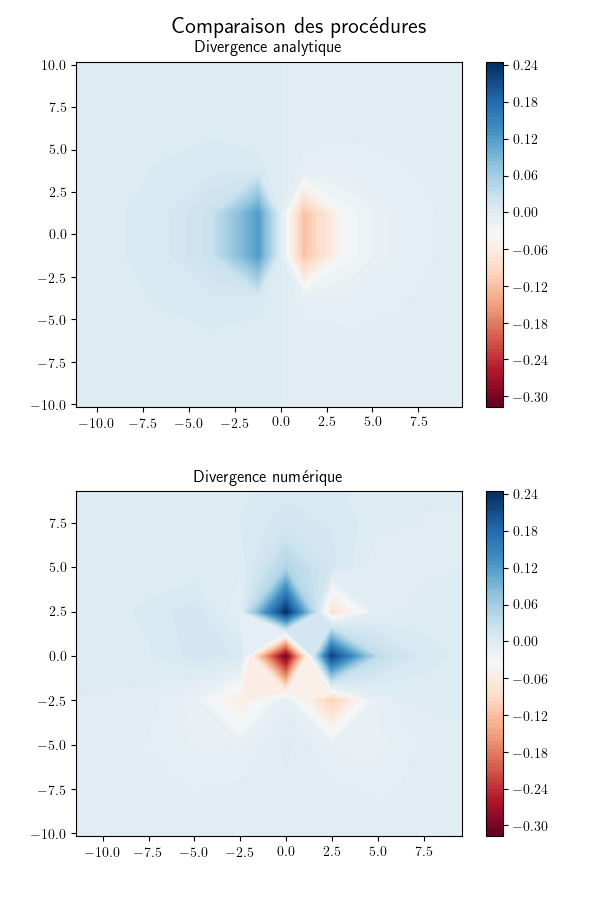

In [32]:
%matplotlib notebook
#nombre de plot (m=3 pour ajouter celui avec filtre, m=2 sinon)
m=2

if m==2:
    plt.rcParams['figure.figsize'] = [6,9]
if m==3:
    plt.rcParams['figure.figsize'] = [6,10]
plot_comparaison_divergence(div_analytique,div_numerique,div_numerique_filtre,"Comparaison des procédures",m)

# Superposition de la carte de champ
## Définition de la fonction de plot

## Plot